
# FIN 580 Midterm Project Xinyi Liu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from numpy import linalg as LA
from numpy.linalg import inv
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

# Data Preparation

In [4]:
# generate a time list from 9:30 to 3: 59
time = 930
time_list = [time,]
for i in range(389):
    time = time + 1
    if time % 100 == 60:
        time += 40
    time_list.append(time)
time_list = np.array(time_list)  

def calculateRV_oneday(df_oneday):
    # Find the end-of-day Time in case it is a short trading day
    this_time_list = time_list[time_list <= df_oneday['Time'].iloc[-1]]
    # Set the index to Time
    df_oneday = df_oneday.set_index('Time')
    # Select data using time_list and forward filling NA to its previous closing price. 
    df_oneday_CP = df_oneday['Close'].reindex(this_time_list)
    df_oneday_CP = df_oneday_CP.fillna(method = 'ffill')
    # Generate the 5-minute closing price
    df_oneday_5min = df_oneday_CP.iloc[4::5]
    # Calculate RV
    Pdiff = np.diff(np.log(df_oneday_5min))
    return np.nansum(Pdiff ** 2)

def calculateRV_onemonth(df_onemonth):  #df_onemonth is a pd series
    return np.nansum(np.diff(np.log(df_onemonth)) ** 2)

### From YahooFinance, calculate monthly volatility from daily closing prices

In [5]:
df_yahoo = pd.read_csv('/Users/xinyi/Courses/FIN580/Midterm/Yahoo_SP.csv')

df_yahoo.index = pd.to_datetime(df_yahoo['Date'])
monthly_RV_yahoo = df_yahoo.groupby(pd.Grouper(freq='M'))['Close'].apply(calculateRV_onemonth)
#df_yahoo.groupby(pd.Grouper(freq='M'))['Close'].get_group(pd.Timestamp('1960-07-31', freq='M'))
monthly_RV_yahoo.name = 'SP500_RV_yahoo'
np.log(monthly_RV_yahoo).plot()

### Calculate monthly volatility from daily volatility from 1983-2017. 

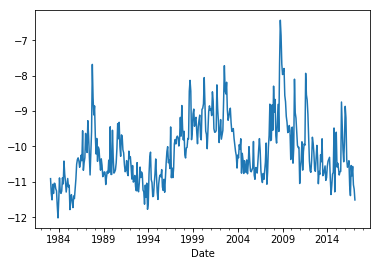

In [157]:
# calculate daily RV
df = pd.read_csv('/Users/xinyi/Courses/FIN580/HW3/dataset/SP500.txt')
daily_RV = df.groupby('Date', sort = False).apply(calculateRV_oneday)
daily_RV.index = pd.to_datetime(daily_RV.index)
# calculate monthly RV by averaging daily RV by month
monthly_RV = daily_RV.groupby(pd.Grouper(freq='M')).mean()
np.log(monthly_RV).plot()

### Macro data 

In [442]:
file_name = '/Users/xinyi/Courses/FIN580/Midterm/current.csv'
df_macro = pd.read_csv(file_name)
df_macro = df_macro[:-3]  # crop at the end of 2018
df_macro.drop(df_macro.index[1:11], inplace=True) # start from 1959/11/1
df_macro.drop(columns=['ACOGNO','ANDENOx','TWEXMMTH', 'UMCSENTx', 'NONBORRES'], inplace=True)
#### Sanity Check ####
#df_macro.iloc[290]['S&P 500']  # Check: 02/1983 S&P Closing price(matches with the intraday SP data)
#df_macro.isna().sum(axis = 1)[100:400]   # from 398, no missing values
### Check number of NaN columns:
index = df_macro.columns[df_macro.isna().sum(axis = 0) != 0]
df_macro[index].isna().sum(axis=0)
df_macro_filled = df_macro.fillna(method='bfill')
df_macro_filled.reset_index(drop=True, inplace=True)
df_macro_filled.shape #row 0: transform. 1/1/1960~1/1/2019

(711, 124)

### transform the data

In [482]:
df_macro_filled.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,6.0,6.0,6.0,6.0000,1.0000
1,11/1/1959,2509.323,2356.0,17.957,283577.2071,18356.08045,22.8466,24.0626,22.7672,32.6455,...,17.929,11.675,2.17,2.57,2.07,285.4,7448.0,13889.0,75.8793,19.5715
2,12/1/1959,2535.041,2382.9,17.937,297999.8075,18271.03618,24.2589,24.7821,23.3164,33.7152,...,17.932,11.700,2.20,2.56,2.11,286.4,7389.0,14058.0,76.1711,19.5715
3,1/1/1960,2543.148,2394.0,17.987,303096.9723,18763.67069,24.8958,25.3866,24.0030,34.7849,...,17.903,11.710,2.22,2.57,2.13,286.7,7362.0,14063.0,75.4515,19.5715
4,2/1/1960,2546.061,2396.2,18.065,307496.8191,18833.15808,24.6743,25.2427,23.9206,34.3887,...,17.904,11.729,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3363,19.5715


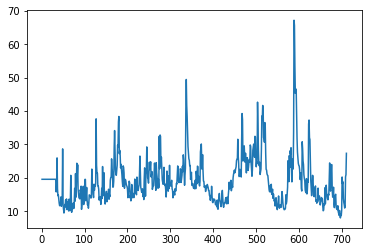

In [444]:
df_macro_filled['VXOCLSx'][1:].plot()   # transformation code = 1

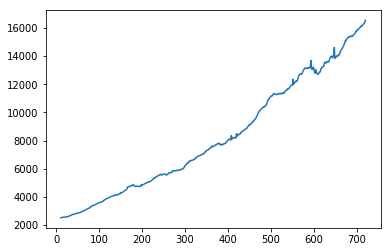

In [24]:
df_macro['RPI'][1:].plot()   # transformation code = 5

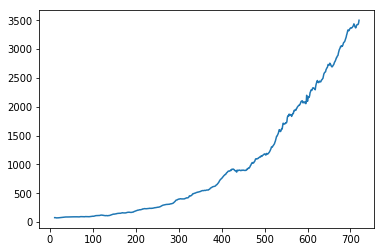

In [483]:
df_macro['INVEST'][1:].plot()   # transformation code = 6

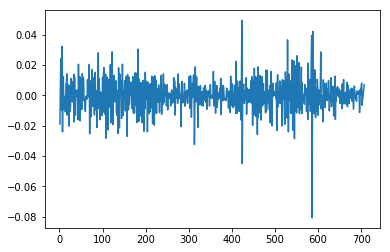

In [486]:
df_transformed['INVEST'][1:].plot()   # transformation code = 6

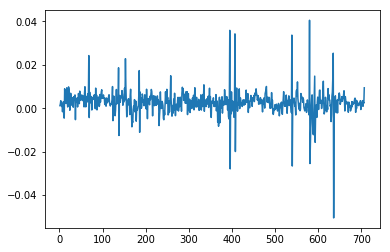

In [481]:
df_transformed['RPI'][1:].plot()   # transformation code = 5

In [445]:
df_transformed = pd.DataFrame()
df_transformed['date'] = df_macro_filled['sasdate'][1:]

for cln in df_macro_filled.columns[1:]:
    tcode = df_macro_filled[cln][0]
    if tcode == 2:
        df_transformed[cln] = (df_macro_filled[cln][1:]).diff()
    if tcode == 3:
        df_transformed[cln] = (df_macro_filled[cln][1:]).diff().diff()
    if tcode == 4:
        df_transformed[cln] = np.log(df_macro_filled[cln][1:])    
    if tcode == 5:
        df_transformed[cln] = (np.log(df_macro_filled[cln][1:])).diff()
    if tcode == 6 or tcode == 7:
        df_transformed[cln] = (np.log(df_macro_filled[cln][1:])).diff().diff()
    if tcode == 7:
        df_transformed[cln] = (df_macro_filled[cln][1:].div(df_macro_filled[cln][1:].shift(1)) - 1).diff()

df_transformed.drop(df_transformed.index[:2], inplace=True) #invalid value encountered during transformatin. 13 Na values.
df_transformed.fillna(method='bfill', inplace=True)
df_transformed.reset_index(drop=True, inplace=True)


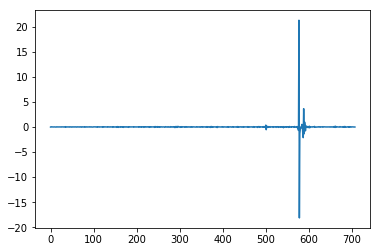

In [80]:
df_transformed['NONBORRES'].plot()

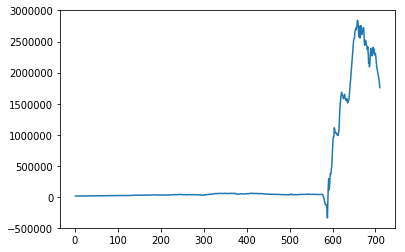

In [81]:
df_macro_filled['NONBORRES'][1:].plot()   # transformation code = 7  dropped

# combine features 

In [446]:
df_transformed['SP500_RV_yahoo'] = np.log(monthly_RV_yahoo[12:-4].values)
df_transformed.shape

(708, 114)

In [84]:
df_transformed

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,SP500_RV_yahoo
0,1/1/1960,0.003193,0.004647,0.002784,0.016960,0.026606,0.025916,0.024100,0.029022,0.031235,...,-0.001786,-0.001285,-0.004680,0.007797,-0.009705,-0.002451,0.004292,-0.011739,-0.013330,-6.983007
1,2/1/1960,0.001145,0.000919,0.004327,0.014412,0.003696,-0.008937,-0.005684,-0.003439,-0.011455,...,0.001674,0.000767,-0.004555,0.003853,-0.004750,-0.000001,0.008268,0.005388,-0.018942,-6.803789
2,3/1/1960,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,...,0.001786,-0.001025,-0.000020,0.030131,-0.004684,0.001738,0.003472,0.000951,0.003490,-6.982725
3,4/1/1960,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,...,0.004439,0.001531,-0.008949,-0.068074,0.000000,-0.001048,0.008678,0.005452,0.024136,-7.005353
4,5/1/1960,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,...,-0.006723,0.000504,0.008949,0.041620,0.000000,0.001035,-0.004827,-0.002067,0.003798,-7.864336
5,6/1/1960,0.000789,-0.000249,-0.000219,0.008606,-0.001364,-0.012650,-0.011414,-0.011467,-0.006841,...,0.000222,-0.000768,-0.004474,-0.011429,0.000000,0.001027,0.005126,0.007420,-0.009981,-7.595821
6,7/1/1960,0.001832,0.001905,0.002028,-0.006865,-0.010099,-0.003479,-0.005760,-0.005783,-0.009197,...,0.001828,0.000672,0.004454,0.007547,0.000000,0.001358,-0.010926,-0.003291,0.032176,-6.970107
7,8/1/1960,-0.001624,-0.002568,-0.000931,-0.001263,0.003414,-0.001162,-0.002309,0.000000,0.002309,...,0.000605,-0.000849,-0.000020,-0.000057,0.004662,0.003378,-0.002572,-0.002301,-0.024113,-7.343834
8,9/1/1960,0.001274,0.000290,0.004757,0.016091,-0.000935,-0.010519,-0.008136,-0.005817,-0.004620,...,-0.001659,0.000334,-0.004435,-0.007491,-0.000022,-0.004125,-0.006991,-0.007052,0.011518,-6.345229
9,10/1/1960,0.002954,0.003147,0.004843,-0.019028,0.008766,-0.001176,0.005817,0.004654,0.010361,...,0.001102,-0.000760,0.004415,0.003724,-0.004640,-0.001368,-0.001930,-0.005247,0.012381,-6.703089


# Generate training and testing 

In [447]:
def standardize(xx, xx_test): # standardize xx. standardize xx_test according to xx_train's statistics.
    return (xx - xx.mean(axis = 0))*1.0 / xx.std(axis = 0), (xx_test- xx.mean(axis = 0))*1.0 / xx.std(axis = 0)

def Generalize_Rollingwindow_Data(i):
    # generate training data
    training_data_without_std = df_transformed.iloc[(i - 359): (i + 1)][df_transformed.columns[1:]] 
    training_x_without_std = training_data_without_std.iloc[: -1].values
    testing_x_without_std = training_data_without_std.iloc[-1].values
    training_x, testing_x = standardize(training_x_without_std, testing_x_without_std) 
    #get the y data.(don't have to standardize y)
    training_y = training_data_without_std['SP500_RV_yahoo'].iloc[1:].values
    testing_y = df_transformed['SP500_RV_yahoo'].iloc[i + 1]
    return training_x, testing_x, training_y, testing_y

def calc_ic(training_x, training_y, reg, degf, T, ic_factor):
    error_sqsum = ((training_y - reg.predict(training_x))**2).sum()
    sigma_hat = error_sqsum / (T - degf)
    aic = np.log(sigma_hat) + degf * ic_factor / T
    return aic

def calc_aic(training_x, training_y, reg, degf, T):
    return calc_ic(training_x, training_y, reg, degf, T, 2)

def calc_bic(training_x, training_y, reg, degf, T):
    return calc_ic(training_x, training_y, reg, degf, T, np.log(T))

def calculate_mean_squared_error(y_hat_list, y_test_list):
    error_square = (np.array(y_hat_list) - np.array(y_test_list)) ** 2
    mse = error_square.sum() / len(y_hat_list)
    return mse

def calculate_R_square(y_hat_list, y_test_list):
    error_square = (np.array(y_hat_list) - np.array(y_test_list)) ** 2
    residual_sum_square = error_square.sum()
    testing_mean = np.array(y_test_list).mean()
    total_sum_square = ((np.array(y_test_list) - testing_mean) ** 2).sum()
    r_square = 1 - (residual_sum_square / total_sum_square)
    return r_square


In [431]:
def calc_ridge_degf(training_x, a):
    XX = np.transpose(training_x).dot(training_x)
    eigenvalue = LA.eigvalsh(XX)
    degf = (eigenvalue / (eigenvalue + a)).sum()
    print(degf)
    return degf
def ridge_model(training_x, testing_x, training_y):
    #alpha_list = np.linspace(0.0001, 0.1, 10)
    alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ic_list = []
    reg_list = []

    for a in alpha_list:   
        reg = Ridge(alpha = a).fit(training_x, training_y)
        degf = calc_ridge_degf(training_x, a)
        ic = calc_aic(training_x, training_y, reg, degf, len(training_y))
        ic_list.append(ic)
        reg_list.append(reg)

    # find the alpha that is associated with minimum IC
    alpha_min = alpha_list[np.argmin(ic_list)]
    reg_min = reg_list[np.argmin(ic_list)]
    relevant_var_number = np.count_nonzero(reg_min.coef_)

    # predict y_hat using tuned lambda for each rolling window
    y_hat = reg_min.predict(testing_x.reshape(1, -1))[0]
    return y_hat, relevant_var_number, alpha_min, reg_min

In [93]:
def lasso_model(training_x, testing_x, training_y):
    alpha_list = np.linspace(0.01, 1, 100)
    ic_list = []
    reg_list = []
    beta_lasso = []
    
    for a in alpha_list:   
        reg = Lasso(alpha = a).fit(training_x, training_y)
        degf = np.count_nonzero(reg.coef_)
        ic = calc_aic(training_x, training_y, reg, degf, len(training_y))
        ic_list.append(ic)
        reg_list.append(reg)

    # find the alpha that is associated with minimum IC
    alpha_min = alpha_list[np.argmin(ic_list)]
    reg_min = reg_list[np.argmin(ic_list)]
    relevant_var_number = np.count_nonzero(reg_min.coef_)
    beta_lasso.append(reg_min.coef_)
    
    # predict y_hat using tuned lambda for each rolling window
    y_hat = reg_min.predict(testing_x.reshape(1, -1))[0]
    return y_hat, relevant_var_number, alpha_min, beta_lasso

In [464]:
training_x, testing_x, training_y, testing_y = Generalize_Rollingwindow_Data(359)
reg = ElasticNet(alpha = 0.01).fit(training_x, training_y)
beta_hat = reg.coef_

In [465]:
beta_hat

array([-0.05560488, -0.0201205 , -0.0331971 ,  0.00383076,  0.03730921,
       -0.        ,  0.        ,  0.        , -0.00821586, -0.03189711,
        0.        , -0.        , -0.05124121, -0.        , -0.01315132,
       -0.        , -0.02577514,  0.001859  ,  0.04626937, -0.        ,
       -0.02610385, -0.00941689,  0.        ,  0.        ,  0.02721829,
       -0.        , -0.02180438,  0.        ,  0.00787439, -0.00979525,
       -0.00325524,  0.01178519,  0.        , -0.04071041,  0.02905695,
        0.        ,  0.        ,  0.02259964,  0.        , -0.07623383,
       -0.        ,  0.07704842, -0.0638111 , -0.02993892,  0.05756624,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00158622,
        0.        ,  0.        , -0.04366414,  0.05836744,  0.0034338 ,
        0.05033002, -0.05733373, -0.00774746,  0.01829868,  0.01220248,
        0.05396269, -0.17225891,  0.01883155, -0.        ,  0.05879918,
       -0.00939894,  0.07308911, -0.04534632, -0.00133007,  0.  

In [474]:
np.nonzero(beta_hat)[0]

array([  0,   1,   2,   3,   4,   8,   9,  12,  14,  16,  17,  18,  20,
        21,  24,  26,  28,  29,  30,  31,  33,  34,  37,  39,  41,  42,
        43,  44,  49,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  64,  65,  66,  67,  68,  72,  73,  74,  78,  79,  82,  83,
        84,  85,  87,  89,  90,  91,  92,  94,  95,  97,  98,  99, 100,
       102, 103, 105, 106, 107, 110, 111, 112])

In [470]:
X_a = training_x[:, np.nonzero(beta_hat)[0]]

In [472]:
X_a.shape

(359, 73)

In [475]:
def calc_elasticnet_degf(training_x, a, beta_hat):
    # calculate degree of freedom according to the elastic net formula
    sparcity_index = np.nonzero(beta_hat)[0]
    #x_a = np.delete(training_x,sparcity_index,axis=1)
    x_a = training_x[:, sparcity_index]
    inverse_x_a = inv((np.transpose(x_a).dot(x_a) + a))
    h_a = x_a.dot(inverse_x_a).dot(np.transpose(x_a))
    degf = h_a.trace()
    print(degf)
    return degf

def elasticnet_model(training_x, testing_x, training_y):
    #alpha_list = np.linspace(0.0001, 0.1, 10)
    alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ic_list = []
    reg_list = []

    for a in alpha_list:   
        reg = ElasticNet(alpha = a).fit(training_x, training_y)
        beta_hat = reg.coef_
        degf = calc_elasticnet_degf(training_x, a, beta_hat)
        ic = calc_aic(training_x, training_y, reg, degf, len(training_y))
        ic_list.append(ic)
        reg_list.append(reg)

    # find the alpha that is associated with minimum IC
    alpha_min = alpha_list[np.argmin(ic_list)]
    reg_min = reg_list[np.argmin(ic_list)]
    relevant_var_number = np.count_nonzero(reg_min.coef_)

    # predict y_hat using tuned lambda for each rolling window
    y_hat = reg_min.predict(testing_x.reshape(1, -1))[0]
    return y_hat, relevant_var_number, alpha_min

In [88]:
#######Random Forest Trees#################
def RandomForest_BlockBootstrap(training_x, testing_x, training_y, testing_y):
    y_hat_allbags = []
    n_bags = 10
    for itr in range(n_bags):
        training_x_onebag, training_y_onebag, _ = blockbootstrap(9, len(training_x[0]), training_x, training_y)
        y_hat_onebag = RandomForest(training_x_onebag, testing_x, training_y_onebag, testing_y)
        y_hat_allbags.append(y_hat_onebag)

    # average of y_hat and coefficients from all the bags
    y_hat = np.array(y_hat_allbags).mean()
    return y_hat
        
def RandomForest(training_x, testing_x, training_y, testing_y):
    rf = RandomForestRegressor(n_estimators=50, max_depth=None, min_samples_split=10, max_features='sqrt', bootstrap=False)
    rf = rf.fit(training_x, training_y)
    y_hat = rf.predict(testing_x.reshape(1, -1))
    return y_hat

# Function that uses block-bootstrap to construct the training set for each rolling window.
def blockbootstrap(n_blocks, n_feature, training_x, training_y):
    # split training_x into 9 blocks, with each has 111 items. 
    n_random = random.sample(range(0,n_blocks), 5)  # each bag contains 5/n_blocks % of the total data
    n_random.sort()

    # split and concatenate to form block bootstrap
    split_list = np.array_split(training_x, n_blocks)
    training_x_onebag_temp = np.concatenate([split_list[i] for i in n_random])
    split_list = np.array_split(training_y, n_blocks)
    training_y_onebag = np.concatenate([split_list[i] for i in n_random])

    # select random features
    feature_randlst = random.sample(range(0, len(training_x[0])), n_feature)
    feature_randlst.sort()
    training_x_onebag = training_x_onebag_temp[:, feature_randlst]
    
    return training_x_onebag, training_y_onebag, feature_randlst

In [154]:
#### Linear boosting#######
def GradientBoostingMachine(training_x, testing_x, training_y, testing_y):
    v = 0.1 # learning rate
    k_iterations_min = 10
    k_iterations_max = 100
    threshold_earlystop = 0.0001
    n_features = len(training_x[0])

    beta_list = []
    mse_convergence = []
    beta_sum = np.zeros(n_features)

    #training_x, testing_x, training_y, testing_y = Generalize_Rollingwindow_Data(i)
    y = training_y
    for k in range(k_iterations_max):
        reg_list = []
        mse_list = []
        for j in range(n_features):
            train_x_single = training_x[:, j].reshape(-1, 1)
            reg = LinearRegression().fit(train_x_single, y)
            y_hat_single = reg.predict(train_x_single)
            mse = ((y_hat_single - y)**2).sum()/len(training_x)
            reg_list.append(reg)
            mse_list.append(mse)

        # find parameter j that has smallest MSE
        index_j = np.argmin(mse_list)
        reg_hat = reg_list[index_j]
        beta_j = reg_hat.coef_[0]

        beta_j_row = np.zeros(n_features)
        beta_j_row[index_j] = beta_j
        beta_sum += beta_j_row * v
        beta_list.append(beta_j_row)

        # store the intercept during the first step
        if k == 0:
            intercept = reg_hat.intercept_

        # plot the convergence curve:
        mse_convergence.append(((training_y - (training_x.dot(beta_sum) + intercept)) ** 2).sum()/999)

        # update the error
        y_hat_at_this_step = training_x.dot(beta_sum) + intercept
        error = training_y - y_hat_at_this_step
        #y_hat_at_this_step = S * y
        #df = trace(S)
        y = error

        # early stopping: if mse is smaller than a threshold: break the loop. 
        if k > k_iterations_min and (mse_convergence[-2] - mse_convergence[-1]) < threshold_earlystop:
            print('early stopping reached at %s iterations' %k)
            break
    return testing_x.dot(beta_sum) + intercept #return y_hat

In [557]:
#######Boosted Trees#################
def BoostedTrees(training_x, testing_x, training_y, testing_y, md, mf):  # tune max_depth, n_estimators
    gbr = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=md, learning_rate=.1, min_samples_leaf=9, min_samples_split=9, max_features=mf)
    gbr = gbr.fit(training_x, training_y)
    y_hat = gbr.predict(testing_x.reshape(1, -1))[0]
    return y_hat

In [385]:
def pca_model(training_x, testing_x, training_y, percent_var):
    #pca = PCA(n_components = 3)
    pca = PCA(n_components = percent_var, svd_solver = 'full')
    new_training_x = pca.fit_transform(training_x)  # return number of samples by number of components
    new_testing_x = pca.transform(testing_x.reshape(1, -1))
    y_hat = LinearRegression().fit(new_training_x, training_y).predict(new_testing_x.reshape(1, -1))[0]
    return y_hat, pca.n_components_

In [558]:
mse_method_list = []
r_square_list = []
y_hat_method_list = []
relevant_var_number_method_list = []
alpha_hat_method_list = []
#all_method = ['ridge', 'adaptive lasso', 'bagging', 'boosting', 'RF', 'boostedtrees']
#all_method = ['bench_rw']
#all_method = ['bench_rw', 'OLS', 'ridge', 'lasso', 'elastic net', 'pca']
all_method = ['boostedtrees']
#all_method = ['elastic net']

for method in all_method:
    alpha_hat_list = []
    relevant_var_number_list = []
    beta_lasso_list = []
    y_hat_list = []
    y_test_list = []
    date_list = []
    
    for i in range(359, len(df_transformed) - 1):
        training_x, testing_x, training_y, testing_y = Generalize_Rollingwindow_Data(i)
        y_test_list.append(testing_y)
        date_list.append(pd.to_datetime(df_transformed.iloc[i]['date']))
        
        if method == 'pca':
            y_hat, rel_var_num = pca_model(training_x, testing_x, training_y, 0.5216)  #rel_var_num is n_components 
            y_hat_list.append(y_hat)
            relevant_var_number_list.append(rel_var_num)
            continue
        if method == 'ridge':
            y_hat, rel_var_num, alpha_hat, reg_min = ridge_model(training_x, testing_x, training_y)
            y_hat_list.append(y_hat)
            alpha_hat_list.append(alpha_hat)
            relevant_var_number_list.append(rel_var_num)
            continue
        if method == 'lasso':
            y_hat, rel_var_num, alpha_hat, beta_lasso = lasso_model(training_x, testing_x, training_y)
            y_hat_list.append(y_hat)
            alpha_hat_list.append(alpha_hat)
            relevant_var_number_list.append(rel_var_num)
            beta_lasso_list.append(beta_lasso)
            continue
        if method == 'elastic net':
            y_hat, rel_var_num, alpha_hat = elasticnet_model(training_x, testing_x, training_y)
            y_hat_list.append(y_hat)
            alpha_hat_list.append(alpha_hat)
            relevant_var_number_list.append(rel_var_num)
            continue
            
        if method == 'bench_rw':
            y_hat_list.append(df_transformed['SP500_RV_yahoo'].iloc[i])
            continue
        if method == 'bagging':
            y_hat, intercept_ave, coef_ave = bagging(training_x, testing_x, training_y)
            # save y_hat, y_test, relevant variable numbers, for each rolling window
            relevant_var_number = np.count_nonzero(coef_ave)
            relevant_var_number_list.append(relevant_var_number)
            y_hat_list.append(y_hat)
            continue
        if method == 'boosting':
            y_hat = GradientBoostingMachine(training_x, testing_x, training_y, testing_y)
            # Note to self: didn't record number of relevant variables. 
            y_hat_list.append(y_hat)
            continue
        if method == 'boostedtrees':
            y_hat = BoostedTrees(training_x, testing_x, training_y, testing_y, 3, 20)
            y_hat_list.append(y_hat)
            continue
        if method == 'RF':
            y_hat = RandomForest_BlockBootstrap(training_x, testing_x, training_y, testing_y)
            y_hat_list.append(y_hat)
            continue
        if method == 'OLS':
            y_hat = LinearRegression().fit(training_x, training_y).predict(testing_x.reshape(1, -1))[0]
            y_hat_list.append(y_hat)
            continue
            
    # Calculate the mean squared error for a total of 1300 rolling windows. 
    mse = calculate_mean_squared_error(y_hat_list, y_test_list)
    mse_method_list.append([method,mse])

    # Calculate R^2
    r_square = calculate_R_square(y_hat_list, y_test_list)
    r_square_list.append([method, r_square])
    
    # store y_hat to the y_hat_method_list
    y_hat_method_list.append([method, y_hat_list])

    # Store the relavant variables for each method in a large list 
    relevant_var_number_method_list.append([method])
    relevant_var_number_method_list.append([relevant_var_number_list])
    
    # Store the alpha_hat for each method in a large list
    alpha_hat_method_list.append([method])
    alpha_hat_method_list.append([alpha_hat_list])
    print(method)


boostedtrees


In [554]:
saved = pd.DataFrame(y_hat_list, columns=['RF'])
saved.to_csv('saved_RF_1.csv', index = False)

In [559]:
r_square_list

[['boostedtrees', 0.33239455415777497]]

In [560]:
mse

0.632438408832609

In [544]:
r_square_list

[['bench_rw', 0.34200279334744954],
 ['OLS', 0.1806670340657599],
 ['ridge', 0.3232199132786284],
 ['lasso', 0.4304133275475647],
 ['elastic net', 0.4353802681394775],
 ['pca', 0.18361312358275106]]

In [545]:
mse_method_list

[['bench_rw', 0.6233362968851326],
 ['OLS', 0.7761734726801702],
 ['ridge', 0.6411297628581862],
 ['lasso', 0.5395829094288296],
 ['elastic net', 0.5348776092784503],
 ['pca', 0.7733825724890345]]

### PCA 

In [414]:
# investigate in how does the percent_var affect the performance
mse_pca = []
r_square_pca = []
pca_var_range = np.linspace(0.1, 0.99, 20)
for percent_var in pca_var_range:
    y_hat_list = []
    y_test_list = []
    for i in range(359, len(df_transformed) - 1):
        training_x, testing_x, training_y, testing_y = Generalize_Rollingwindow_Data(i)
        y_test_list.append(testing_y)
        
        y_hat, rel_var_num = pca_model(training_x, testing_x, training_y, percent_var)  #rel_var_num is n_components 
        y_hat_list.append(y_hat)
            
    # Calculate the mean squared error for a total of 1300 rolling windows. 
    mse = calculate_mean_squared_error(y_hat_list, y_test_list)
    mse_pca.append(mse)

    # Calculate R^2
    r_square = calculate_R_square(y_hat_list, y_test_list)
    r_square_pca.append(r_square)
    
index = np.argmax(np.array(r_square_pca))
pca_var_range[index]   

0.521578947368421

Text(0, 0.5, 'Out-of-sample R-square')

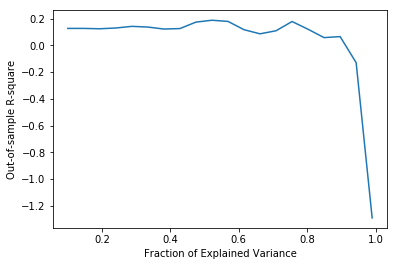

In [547]:
plt.plot(pca_var_range, r_square_pca)
plt.xlabel("Fraction of Explained Variance")
plt.ylabel("Out-of-sample R-square")

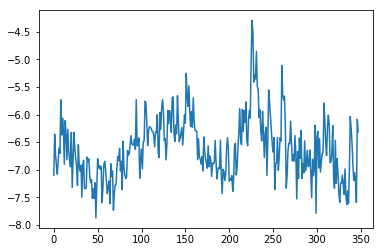

In [144]:
plt.plot(y_hat_list)  # lasso

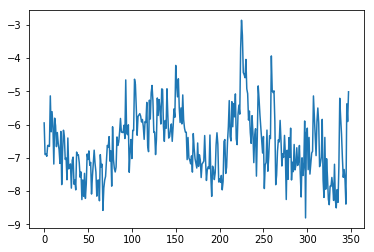

In [142]:
plt.plot(y_test_list)

[['RF', 0.3110306824154505]]
[['boosting', 0.4397719800416624]]

In [96]:
# Get some insight into the variables selected by Lasso
temp = np.count_nonzero(np.array(beta_lasso_list).reshape(348, -1),axis=0)  # len = 114
dftemp_lasso_selected = pd.DataFrame(temp,df_transformed.columns[1:], columns=['count'])
dftemp_lasso_selected.sort_values(by=['count'], ascending=False)

,count
SP500_RV_yahoo,348
USWTRADE,187
DDURRG3M086SBEA,137
IPMAT,120
PERMITMW,115
USGOOD,81
CPIAPPSL,75
M2REAL,74
RPI,71
USGOVT,65


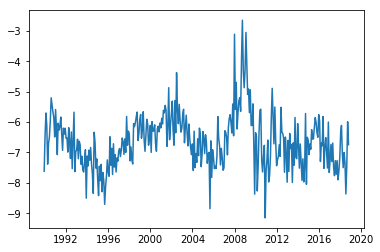

In [428]:
plt.plot(date_list, y_hat_list)

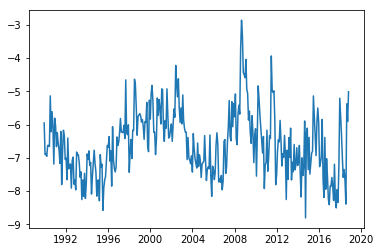

In [383]:
plt.plot(date_list, y_test_list)

# Autoregressive Benchmark model 

In [495]:
#generate autoregression data
del df_ar
RV_yahoo = df_transformed['SP500_RV_yahoo']
df_ar = RV_yahoo
for lag in range(1, 30):
    col = RV_yahoo.shift(lag)
    col.name = lag
    df_ar = pd.concat([df_ar, col], axis = 1)

In [496]:
df_ar

,SP500_RV_yahoo,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-6.983007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-6.803789,-6.983007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-6.982725,-6.803789,-6.983007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-7.005353,-6.982725,-6.803789,-6.983007,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-7.595821,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-6.970107,-7.595821,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-7.343834,-6.970107,-7.595821,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-6.345229,-7.343834,-6.970107,-7.595821,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-6.703089,-6.345229,-7.343834,-6.970107,-7.595821,-7.864336,-7.005353,-6.982725,-6.803789,-6.983007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [515]:
def generate_ar_data(df_ar, i, lag):
    # generate x data
    trainx_without_std = df_ar.iloc[(i - 360 + lag):i][df_ar.columns[1:(lag + 1)]].values
    testx_without_std = df_ar[df_ar.columns[1:(lag + 1)]].iloc[i].values
    trainx, testx = standardize(trainx_without_std, testx_without_std) 
    trainy = df_ar.iloc[(i - 360 + lag):i][df_ar.columns[0]].values
    testy = df_ar.iloc[i][df_ar.columns[0]]
    return trainx, trainy, testx, testy

def calc_aic(training_x, training_y, reg, degf, T):
    return calc_ic(training_x, training_y, reg, degf, T, 2)

def calc_aic_ar(trainx, trainy, reg, lag, T):
    error_sqsum = ((trainy - reg.predict(trainx)) ** 2).sum()
    sigma_hat = error_sqsum / T  # T or (T-lag)?
    aic = T * np.log(sigma_hat) + 2 * lag
    return aic

In [540]:
y_test_list = []
y_hat_list = []
lag_list = []
date_list = []
for i in range(360, len(RV_yahoo)): # range(360, len(RV_yahoo)) # i = 360   # i = 360~1990/1/1
    ic_list = []
    reg_list = []
    testx_list = []
    date_list.append(pd.to_datetime(df_transformed.iloc[i]['date']))
    
    for lag in range(1, 12):
        trainx, trainy, testx, testy = generate_ar_data(df_ar, i, lag)
        reg = LinearRegression().fit(trainx, trainy)
        ic = calc_aic(trainx, trainy, reg, lag, 360)
        ic_list.append(ic)
        reg_list.append(reg)
        testx_list.append(testx)

    # find the optimal order for each rolling window
    #ic_list = abs(np.array(ic_list))   # 我的AIC都是负的？
    
    lag_min = np.argmin(ic_list) + 1
    lag_list.append(lag_min)
    reg_min = reg_list[np.argmin(ic_list)]
    testx_min = testx_list[np.argmin(ic_list)]
    y_hat = reg_min.predict(testx_min.reshape(1, -1))[0]
    
    y_test_list.append(testy)
    y_hat_list.append(y_hat)

# Calculate R^2
r_square = calculate_R_square(y_hat_list, y_test_list)

# Calculate the mean squared error for a total of 1300 rolling windows. 
mse = calculate_mean_squared_error(y_hat_list, y_test_list)

In [536]:
def plot_squared_error(date_list, y_hat_list, y_test_list):
    error_square = (np.array(y_hat_list) - np.array(y_test_list)) ** 2
    plt.plot(date_list, error_square)

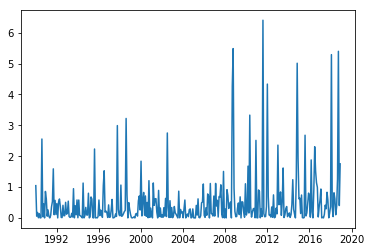

In [542]:
plot_squared_error(date_list, y_hat_list, y_test_list)

r_square = 0.4770141654071861  for a maximum lag of 10
r_square = 0.4769664173446059 for a maximum lag of 12, mse = 0.4955
r_square = 0.4775 for a maximum lag of 6, mse = 0.4949
r_square = 0.47711 for a maximum lag of 24, mse = 0.4953
r_square = 0.47080104827100466 for a maximum lag of 3, mse = 0.5013
r_square = 0.4728544768515843 for a maximum lag of 5
r_square = 0.47024860256300005 for a maximum lag of 30
r_square = 0.47464000847029264 for a maximum lag of 20
r_square = 0.4751096459629346

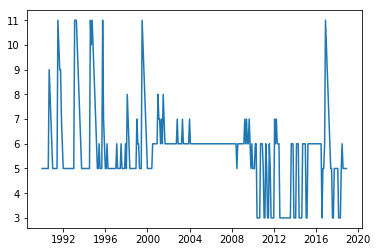

In [531]:
plt.plot(date_list, lag_list)

# Neural Network Training

In [421]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(training_x[0])]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [422]:
model = build_model()

In [423]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7360      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,585
Trainable params: 11,585
Non-trainable params: 0
_________________________________________________________________


In [424]:
example_batch = training_x[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.1688626 ],
       [-0.13615778],
       [ 2.321486  ],
       [ 1.3037316 ],
       [ 0.849785  ],
       [ 1.6387405 ],
       [ 1.6152623 ],
       [ 2.5549335 ],
       [ 1.5647819 ],
       [ 0.01973414]], dtype=float32)

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

In [ ]:
# Plot number of relevant variables for each method
date_list = [da_df_2008.index[i] for i in range(999, (len(da_df_2008) - 1))]
fig, axs = plt.subplots(4, 2, constrained_layout=True, figsize= (12,12))
axs[0, 0].plot(date_list, y_hat_method_list[0][1])
axs[0, 0].set_title(y_hat_method_list[0][0])
axs[0, 1].plot(date_list, y_hat_method_list[1][1])
axs[0, 1].set_title(y_hat_method_list[1][0])
axs[1, 0].plot(date_list, y_hat_method_list[2][1])
axs[1, 0].set_title(y_hat_method_list[2][0])
axs[1, 1].plot(date_list, y_hat_method_list[3][1])
axs[1, 1].set_title(y_hat_method_list[3][0])
axs[2, 0].plot(date_list, y_hat_method_list[4][1])
axs[2, 0].set_title(y_hat_method_list[4][0])
axs[2, 1].plot(date_list, y_hat_method_list[5][1])
axs[2, 1].set_title(y_hat_method_list[5][0])
axs[3, 0].plot(date_list, y_test_list)
axs[3, 0].set_title('y_test')
axs[2, 0].set_ylabel('Forecasted one-day-ahead log RV')
plt.show()